# <span style="color:green; font-family:cursive">Detectron2  </span>


## <span style="color:green; font-family:cursive">1. Object Detection on COCO </span>

[link to yaml from model.zoo](https://github.com/facebookresearch/detectron2/blob/main/configs/COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml)

In [1]:
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.projects.panoptic_deeplab import (
    PanopticDeeplabDatasetMapper,
    add_panoptic_deeplab_config,
)
from detectron2.projects import point_rend

import warnings 
warnings.filterwarnings('ignore')



import cv2 as cv

import numpy as np
import matplotlib.pyplot as plt 


import torch
print(torch.__version__, torch.cuda.is_available())

1.13.0+cu117 True


(797, 1200, 3)


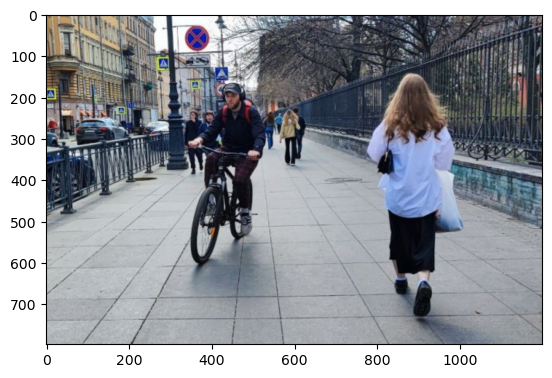

In [2]:
img = cv.imread('./images/street_spb.jpg')
print(img.shape)

plt.imshow(img[..., ::-1]); #bgr to rgb

In [3]:
def cv_imshow(im):
    im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5))
    plt.imshow(im)
    plt.axis('off');

In [7]:
# Create config
cfg = get_cfg()

cfg_path = 'C:/Users/RedmiBook/detectron2/configs/'
yaml = "COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"

cfg.merge_from_file(cfg_path + yaml)
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_101_FPN_3x/137851257/model_final_f6e8b1.pkl"

cfg.MODEL.DEVICE = 'cpu'


In [8]:
predictor = DefaultPredictor(cfg)
output = predictor(img)

In [9]:
output

{'instances': Instances(num_instances=16, image_height=797, image_width=1200, fields=[pred_boxes: Boxes(tensor([[ 780.5010,  142.4402,  984.7937,  731.5660],
         [ 340.8600,  162.4589,  531.0744,  522.7814],
         [ 564.3679,  226.1879,  613.8193,  370.3236],
         [ 347.7821,  322.3273,  511.7435,  601.5726],
         [ 337.0905,  232.5406,  378.1591,  388.3228],
         [ 525.6538,  236.0195,  555.0741,  328.2474],
         [  73.7340,  251.0736,  199.1083,  314.5471],
         [ 553.9094,  238.7470,  572.7578,  289.0655],
         [ 599.2288,  226.7926,  629.6975,  348.2094],
         [ 241.3757,  259.1367,  299.3350,  291.5156],
         [   0.0000,  284.3662,   31.5500,  320.2328],
         [ 937.8704,  366.3251, 1013.7030,  530.5764],
         [ 360.1109,  233.3361,  407.1904,  371.2120],
         [ 801.1979,  309.9494,  840.0584,  389.0179],
         [ 423.0417,  210.7166,  498.2117,  272.5783],
         [ 365.2057,  232.4104,  407.8706,  290.9551]])), scores: tensor

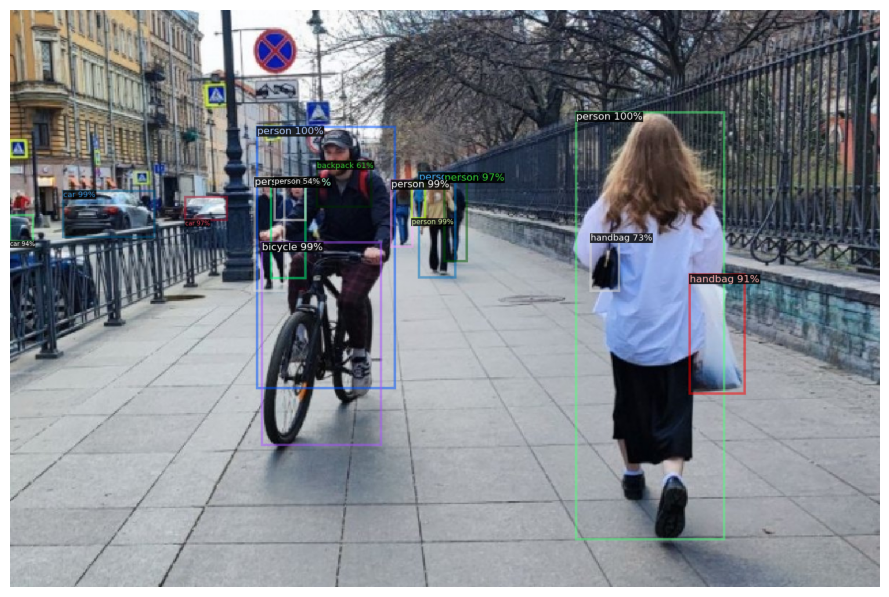

In [12]:
v = Visualizer(img[:,:,::-1], metadata = 
               MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), 
               scale=1.2, 
               instance_mode=ColorMode.IMAGE)

out = v.draw_instance_predictions(output["instances"].to("cpu"))

cv_imshow(out.get_image()[:, :, ::-1])

## <span style="color:green; font-family:cursive">2. Cityscapes Instance Segmentation  </span>

[link to yaml from model.zoo](https://github.com/facebookresearch/detectron2/blob/main/configs/Cityscapes/mask_rcnn_R_50_FPN.yaml)

now let's use weights directly from detectron2.model_zoo:

- PATH = `model_zoo.get_config_file(yaml)`
- WEIGHTS= `model_zoo.get_checkpoint_url(yaml)`

In [13]:
cfg = get_cfg()

yaml =  "Cityscapes/mask_rcnn_R_50_FPN.yaml"

cfg.merge_from_file(model_zoo.get_config_file(yaml))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(yaml)

cfg.MODEL.DEVICE = 'cpu'

In [14]:
predictor = DefaultPredictor(cfg)
output = predictor(img)

In [15]:
output.keys()

dict_keys(['instances'])

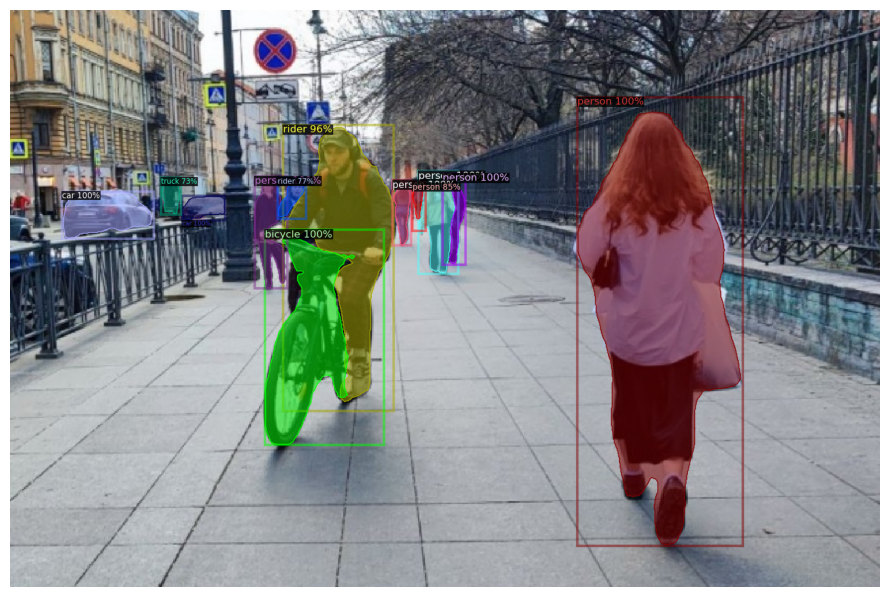

In [16]:
v = Visualizer(img[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2, instance_mode=ColorMode.IMAGE)

out = v.draw_instance_predictions(output["instances"].to("cpu"))

cv_imshow(out.get_image()[:, :, ::-1])

In [17]:
pred_classes = output['instances'].pred_classes.cpu().tolist()
class_names =MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
pred_class_names = list(map(lambda x: class_names[x], pred_classes))
pred_class_names

['person',
 'person',
 'person',
 'person',
 'person',
 'car',
 'bicycle',
 'car',
 'rider',
 'person',
 'rider',
 'truck']

In [24]:
boxes = output['instances'].pred_boxes.tensor.cpu().numpy()
masks = output['instances'].pred_masks.cpu().numpy()

## <span style="color:green; font-family:cursive">3.Cityscapes Semantic Segmentation (DeepLab) </span>

[link to yaml from Deeplab](https://github.com/facebookresearch/detectron2/blob/main/projects/DeepLab/configs/Cityscapes-SemanticSegmentation/deeplab_v3_plus_R_103_os16_mg124_poly_90k_bs16.yaml)

In [260]:
cfg = get_cfg()
add_deeplab_config(cfg)


cfg_path = 'C:/Users/RedmiBook/detectron2/projects/DeepLab/configs/Cityscapes-SemanticSegmentation/'
yaml ='deeplab_v3_plus_R_103_os16_mg124_poly_90k_bs16.yaml'

cfg.merge_from_file(cfg_path + yaml)

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.INPUT.CROP.ENABLED = False

cfg.MODEL.WEIGHTS = './weights/model_final_a8a355.pkl'

cfg.MODEL.DEVICE = 'cuda'

In [261]:
predictor = DefaultPredictor(cfg)
output = predictor(img)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [267]:
output.keys()

dict_keys(['instances'])

[docs: Visualizer.draw_sem_seg](https://detectron2.readthedocs.io/en/latest/modules/utils.html#detectron2.utils.visualizer.Visualizer.draw_sem_seg)

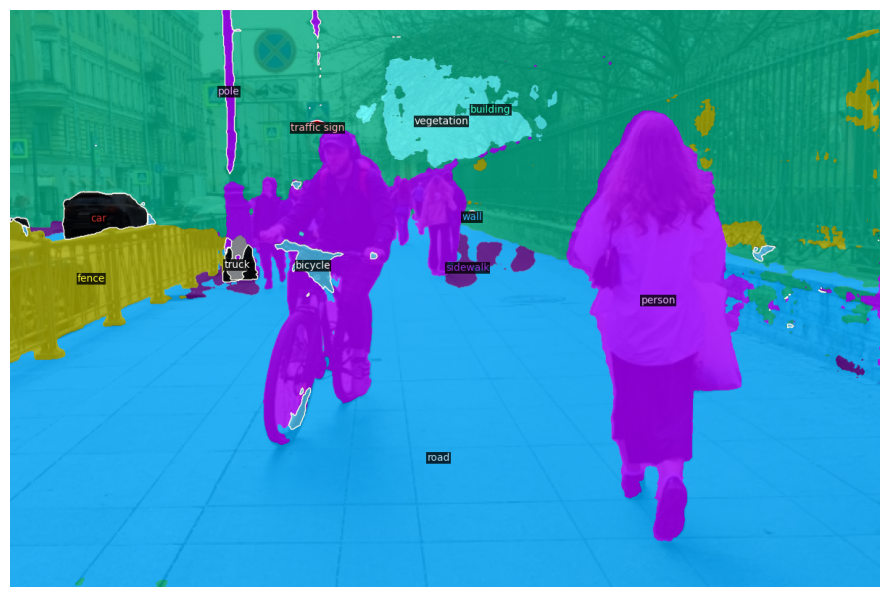

In [155]:
metadata = MetadataCatalog.get('cityscapes_fine_sem_seg_train') # or cfg.DATASETS.TRAIN[0]


v = Visualizer(img[:,:,::-1],
               metadata= metadata,
               scale=1,
               instance_mode=ColorMode.SEGMENTATION)


sem_seg = torch.max(output["sem_seg"],dim=0)[1]
sem_seg = sem_seg.to("cpu")
sem_seg = sem_seg.numpy()


out = v.draw_sem_seg(sem_seg, area_threshold=None, alpha=0.8)

cv_imshow(out.get_image()[:, :, ::-1])

## <span style="color:green; font-family:cursive">4.Cityscapes Panoptic Segmentation  (Panoptic DeepLab) </span>

[link to yaml from Deeplab](https://github.com/facebookresearch/detectron2/blob/main/projects/Panoptic-DeepLab/configs/Cityscapes-PanopticSegmentation/panoptic_deeplab_R_52_os16_mg124_poly_90k_bs32_crop_512_1024_dsconv.yaml)

In [8]:
from detectron2.projects.panoptic_deeplab import (
    PanopticDeeplabDatasetMapper,
    add_panoptic_deeplab_config,
)

cfg = get_cfg()
add_panoptic_deeplab_config(cfg)

cfg.merge_from_file('C:/Users/RedmiBook/detectron2/projects/Panoptic-DeepLab/configs/Cityscapes-PanopticSegmentation/panoptic_deeplab_R_52_os16_mg124_poly_90k_bs32_crop_512_1024_dsconv.yaml')

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.INPUT.CROP.ENABLED = False

cfg.MODEL.WEIGHTS = "detectron2://PanopticDeepLab/Cityscapes-PanopticSegmentation/panoptic_deeplab_R_52_os16_mg124_poly_90k_bs32_crop_512_1024_dsconv/model_final_23d03a.pkl"
cfg.MODEL.DEVICE = 'cuda'

In [9]:
predictor = DefaultPredictor(cfg)
output = predictor(img)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [10]:
output.keys()

dict_keys(['sem_seg', 'panoptic_seg', 'instances'])

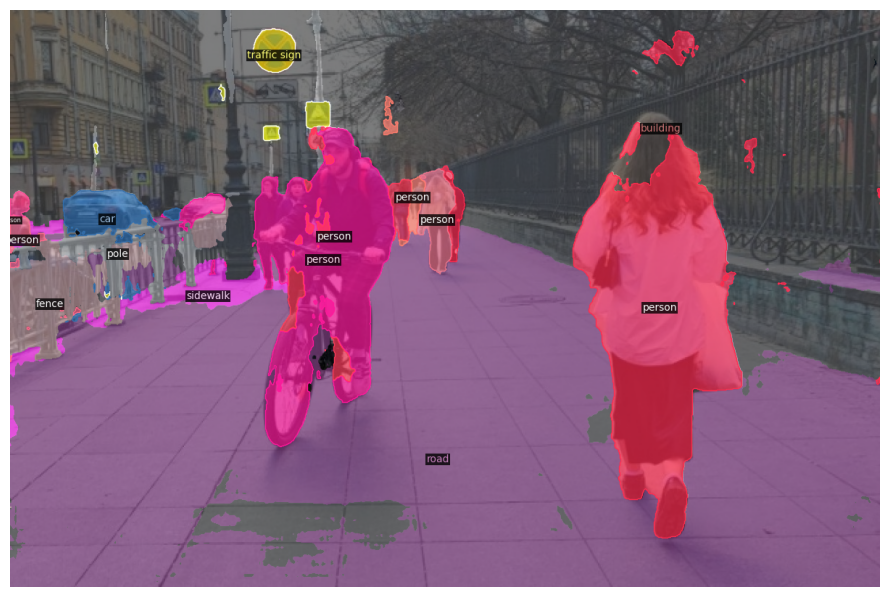

In [11]:
panoptic_seg, segments_info = predictor(img)["panoptic_seg"]

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv_imshow(out.get_image()[:, :, ::-1])

## <span style="color:green; font-family:cursive">5.COCO Panoptic Segmentation</span>


In [8]:
cfg = get_cfg()
add_deeplab_config(cfg)

yaml =  "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"

cfg.merge_from_file(model_zoo.get_config_file(yaml))

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.INPUT.CROP.ENABLED = False

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(yaml)

cfg.MODEL.DEVICE = 'cuda'


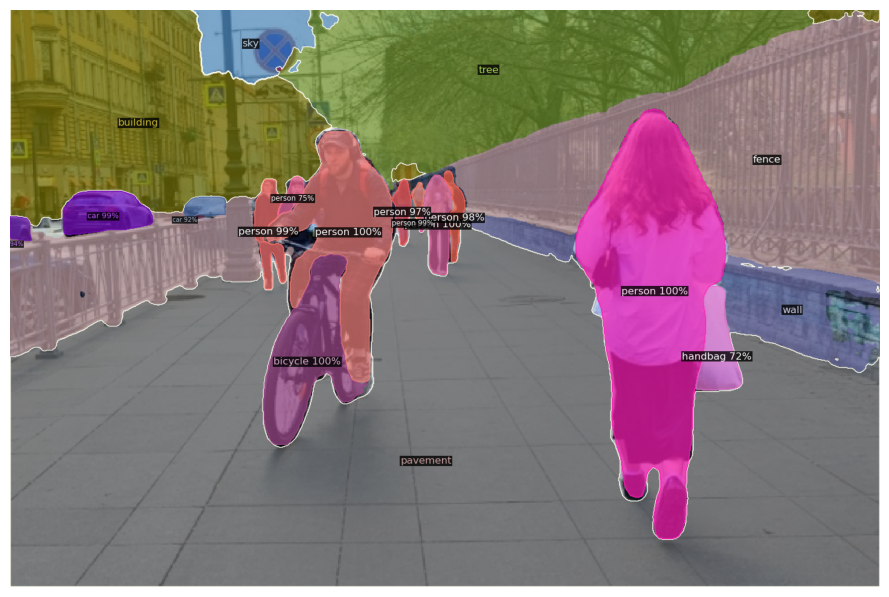

In [9]:
# panoptic segmentation
predictor = DefaultPredictor(cfg)


panoptic_seg, segments_info = predictor(img)["panoptic_seg"]

v = Visualizer(img[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv_imshow(out.get_image()[:, :, ::-1])

In [6]:
segments_info

[{'id': 1,
  'isthing': True,
  'score': 0.9990043044090271,
  'category_id': 0,
  'instance_id': 0,
  'area': 71518.0},
 {'id': 2,
  'isthing': True,
  'score': 0.9987359642982483,
  'category_id': 0,
  'instance_id': 1,
  'area': 26454.0},
 {'id': 3,
  'isthing': True,
  'score': 0.9978025555610657,
  'category_id': 1,
  'instance_id': 2,
  'area': 18127.0},
 {'id': 4,
  'isthing': True,
  'score': 0.9969934225082397,
  'category_id': 0,
  'instance_id': 3,
  'area': 4205.0},
 {'id': 5,
  'isthing': True,
  'score': 0.9931039214134216,
  'category_id': 2,
  'instance_id': 4,
  'area': 5938.0},
 {'id': 6,
  'isthing': True,
  'score': 0.9926906228065491,
  'category_id': 0,
  'instance_id': 5,
  'area': 3602.0},
 {'id': 7,
  'isthing': True,
  'score': 0.9850397109985352,
  'category_id': 0,
  'instance_id': 6,
  'area': 560.0},
 {'id': 8,
  'isthing': True,
  'score': 0.9779359102249146,
  'category_id': 0,
  'instance_id': 7,
  'area': 1655.0},
 {'id': 9,
  'isthing': True,
  'score

<span style="color:green; font-family:cursive">When 'isthing' == False we use stuff_classes :</span>

`class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes`

<span style="color:green; font-family:cursive">stuff_classes is used by semantic and panoptic segmentation tasks</span>


<span style="color:green; font-family:cursive">In this example 37, 38, 40, 44, 50, 52 classes are correct</span>


In [211]:
pred_classes = [i['category_id'] for i in segments_info]
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes
pred_class_names = list(map(lambda x: class_names[x], pred_classes))
dict(zip(pred_classes,pred_class_names)) 

{0: 'things',
 1: 'banner',
 2: 'blanket',
 26: 'snow',
 37: 'tree',
 38: 'fence',
 40: 'sky',
 44: 'pavement',
 50: 'building',
 52: 'wall'}


<span style="color:green; font-family:cursive">When 'isthing' == True we use thing_classes :</span>

`class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes`

<span style="color:green; font-family:cursive">thing_classes is used by all instance detection/segmentation tasks</span>

[docs link](https://detectron2.readthedocs.io/en/latest/tutorials/datasets.html#metadata-for-datasets)

<span style="color:green; font-family:cursive">In this example 0, 1, 2, 26 classes are correct</span>


In [212]:
pred_classes = [i['category_id'] for i in segments_info]
class_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
pred_class_names = list(map(lambda x: class_names[x], pred_classes))
dict(zip(pred_classes,pred_class_names)) 

{0: 'person',
 1: 'bicycle',
 2: 'car',
 26: 'handbag',
 37: 'surfboard',
 38: 'tennis racket',
 40: 'wine glass',
 44: 'spoon',
 50: 'broccoli',
 52: 'hot dog'}

In [214]:
# sum up
thing_classes = [i['category_id'] for i in segments_info if i['isthing'] == True]
stuff_classes = [i['category_id'] for i in segments_info if i['isthing'] == False]
print(thing_classes, stuff_classes)

thing_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
stuff_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes

pred_class_names = list(map(lambda x: thing_names[x], thing_classes)) + list(map(lambda x: stuff_names[x], stuff_classes))
pred_class_names

[0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 2, 0, 26] [37, 38, 40, 44, 50, 52]


['person',
 'person',
 'bicycle',
 'person',
 'car',
 'person',
 'person',
 'person',
 'person',
 'car',
 'car',
 'person',
 'handbag',
 'tree',
 'fence',
 'sky',
 'pavement',
 'building',
 'wall']

## <span style="color:green; font-family:cursive">6.COCO Panoptic Segmentation  on Video </span>
      
    yaml =  "COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"

In [1]:
%%writefile panoptic_seg.py

import cv2 as cv
import argparse
import matplotlib.pyplot as plt
import math
import numpy as np
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog
from detectron2 import model_zoo
from detectron2.projects.deeplab import add_deeplab_config

import warnings 
warnings.filterwarnings('ignore')
import torch
import imutils

parser = argparse.ArgumentParser('run video')
parser.add_argument('-v', '--video_dir', type = str, help ='video directory')
parser.add_argument('-yaml', '--config_yaml', type = str, help ='config yaml file')
parser.add_argument('-m', '--model_type', type = str, help ='model type')
args = parser.parse_args()

    
    
def run_video(video_dir, config_yaml, model_type):
    
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(config_yaml))
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.INPUT.CROP.ENABLED = False
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_yaml)
    cfg.MODEL.DEVICE = 'cuda'
    predictor = DefaultPredictor(cfg)
    
    
    # run video
    cap = cv.VideoCapture(video_dir)   #for webcam: 0 if single, if multiple: choose for e.g 1; if no rto -> video_dir

    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    size =(width, height)
    fourcc= cv.VideoWriter_fourcc(*"MP4V")

    # VideoWriter for output video
    video_writer = cv.VideoWriter(video_dir[:-4] +'_output.mp4', fourcc, 20.0, size)

    while True:
        isTrue, frame = cap.read()
        if isTrue:    
            panoptic_seg, segments_info = predictor(frame)["panoptic_seg"]

            v = Visualizer(frame[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
            

            output = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
            
            
            # get labels for panoptic seg
            thing_classes = [i['category_id'] for i in segments_info if i['isthing'] == True]
            stuff_classes = [i['category_id'] for i in segments_info if i['isthing'] == False]

            thing_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).thing_classes
            stuff_names = MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).stuff_classes
            pred_class_names = list(map(lambda x: thing_names[x], thing_classes)) + list(map(lambda x: stuff_names[x], stuff_classes))  
            
            
            # display and save result
            cv.cvtColor(output.get_image()[:, :, ::-1], cv.COLOR_BGR2RGB)
            cv.imshow('result', output.get_image()[:, :, ::-1])
            video_writer.write(output.get_image()[:, :, ::-1])
            cv.waitKey(1)
            
            
        else:
            break
                    
    cap.release()
    video_writer.release()
    cv.destroyAllWindows()
    
            
        

if __name__=='__main__':
    run_video(args.video_dir, args.config_yaml, args.model_type)


Overwriting panoptic_seg.py


## <span style="color:green; font-family:cursive">7.Cityscapes Semantic + PointRend </span>
[link](https://github.com/facebookresearch/detectron2/blob/main/projects/PointRend/configs/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes.yaml)


In [7]:
cfg = get_cfg()
point_rend.add_pointrend_config(cfg)

cfg.merge_from_file('C:/Users/RedmiBook/detectron2/projects/PointRend/configs/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes.yaml')
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.INPUT.CROP.ENABLED = False

cfg.MODEL.WEIGHTS = "detectron2://PointRend/SemanticSegmentation/pointrend_semantic_R_101_FPN_1x_cityscapes/202576688/model_final_cf6ac1.pkl"
cfg.MODEL.DEVICE = 'cuda'


In [8]:
predictor = DefaultPredictor(cfg)
output = predictor(img)

The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std


In [9]:
output.keys()

dict_keys(['sem_seg'])

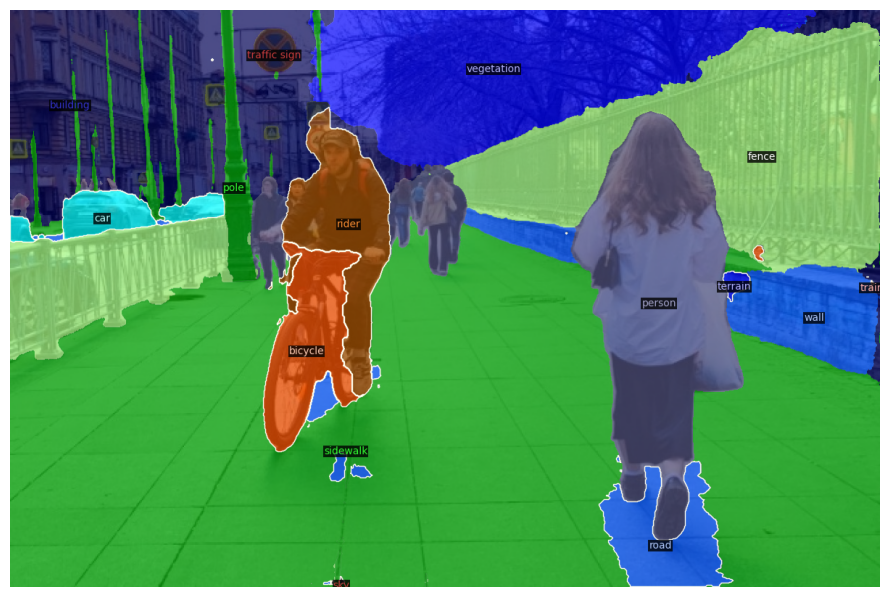

In [20]:
v = Visualizer(img[:,:,::-1],
               metadata= MetadataCatalog.get(cfg.DATASETS.TRAIN[0]),
               scale=1,
               instance_mode=ColorMode.SEGMENTATION)


sem_seg = torch.max(output["sem_seg"],dim=0)[1]
sem_seg = sem_seg.to("cpu")
sem_seg = sem_seg.numpy()


out = v.draw_sem_seg(sem_seg, area_threshold=None, alpha=0.7)

cv_imshow(out.get_image()[:, :, ::-1])